### Big Data Final Project - Million Song Dataset

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as F
import pyspark.sql.functions as f
#create a Spark application
spark = SparkSession.builder.appName('BigData').getOrCreate()

In [2]:
#store the Spark Context in a variable. Sometimes the Context is provided directly from the environment
sc = spark.sparkContext
sc.version

'2.4.5'

# Load JSON Files

In [3]:
from functools import reduce  
from pyspark.sql import DataFrame

In [4]:
df1 = spark.read.json("gs://bdmillionsong/data_file_k.json", multiLine=True)
df2 = spark.read.json("gs://bdmillionsong/data_file_y.json", multiLine=True)

In [5]:
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

df=unionAll(df1, df2)

In [8]:
df.printSchema()

root
 |-- song_albumID: string (nullable = true)
 |-- song_albumName: string (nullable = true)
 |-- song_artistID: string (nullable = true)
 |-- song_artistLatitude: string (nullable = true)
 |-- song_artistLocation: string (nullable = true)
 |-- song_artistLongitude: string (nullable = true)
 |-- song_artistName: string (nullable = true)
 |-- song_danceability: string (nullable = true)
 |-- song_duration: string (nullable = true)
 |-- song_hotness: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- song_keySignature: string (nullable = true)
 |-- song_keySignatureConfidence: string (nullable = true)
 |-- song_mfcc: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- song_tempo: string (nullable = true)
 |-- song_timeSignature: string (nullable = true)
 |-- song_timeSignatureConfidence: string (nullable = true)
 |-- song_title: string (nullable = true)
 |-- song_year: string (nullable = true)



## Exploratory Data Analaysis:

In [8]:
df.describe('song_duration').show()

+-------+------------------+
|summary|     song_duration|
+-------+------------------+
|  count|             76799|
|   mean|250.04699908475405|
| stddev|129.18389323443276|
|    min|           0.46975|
|    max|         994.14159|
+-------+------------------+



## Remove single quotes from string objects

In [6]:
df = df.withColumn('song_id',regexp_replace('song_id','\'',''))

In [7]:
df = df.withColumn('song_artistID',regexp_replace('song_artistID','\'',''))

In [8]:
df = df.withColumn('song_artistLocation',regexp_replace('song_artistLocation','\'',''))

In [9]:
df = df.withColumn('song_artistName',regexp_replace('song_artistName','\'',''))

In [10]:
df = df.withColumn('song_title',regexp_replace('song_title','\'',''))

In [11]:
df = df.withColumn('song_albumName',regexp_replace('song_albumName','\'',''))

## Convert datatypes from string

In [12]:
from pyspark.sql.functions import col, column

df = df.withColumn("song_artistLongitude",col("song_artistLongitude").cast("double"))
df = df.withColumn("song_albumID",col("song_albumID").cast("integer"))
df = df.withColumn("song_artistLatitude",col("song_artistLatitude").cast("double"))
df = df.withColumn("song_artistLongitude",col("song_artistLongitude").cast("double"))
df = df.withColumn("song_danceability",col("song_danceability").cast("integer"))
df = df.withColumn("song_duration",col("song_duration").cast("double"))
df = df.withColumn("song_hotness",col("song_hotness").cast("double"))
df = df.withColumn("song_keySignature",col("song_keySignature").cast("integer"))
df = df.withColumn("song_keySignatureConfidence",col("song_keySignatureConfidence").cast("double"))
df = df.withColumn("song_tempo",col("song_keySignatureConfidence").cast("double"))
df = df.withColumn("song_timeSignature",col("song_timeSignature").cast("integer"))
df = df.withColumn("song_timeSignatureConfidence",col("song_timeSignatureConfidence").cast("double"))
df = df.withColumn("song_year",col("song_year").cast("integer"))

In [13]:
df.printSchema()

root
 |-- song_albumID: integer (nullable = true)
 |-- song_albumName: string (nullable = true)
 |-- song_artistID: string (nullable = true)
 |-- song_artistLatitude: double (nullable = true)
 |-- song_artistLocation: string (nullable = true)
 |-- song_artistLongitude: double (nullable = true)
 |-- song_artistName: string (nullable = true)
 |-- song_danceability: integer (nullable = true)
 |-- song_duration: double (nullable = true)
 |-- song_hotness: double (nullable = true)
 |-- song_id: string (nullable = true)
 |-- song_keySignature: integer (nullable = true)
 |-- song_keySignatureConfidence: double (nullable = true)
 |-- song_mfcc: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- song_tempo: double (nullable = true)
 |-- song_timeSignature: integer (nullable = true)
 |-- song_timeSignatureConfidence: double (nullable = true)
 |-- song_title: string (nullable = true)
 |-- song_year: integer (nullable = true)



## Replace NaN with 0

In [14]:
df = df.na.fill(0)

# Feature Engineering

In [16]:
import numpy as np
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
df_filtered = df.where(size(col('song_mfcc')) >= 7200)
df_filtered = df_filtered.withColumn("new_mfcc", F.expr("slice(song_mfcc, 6000, 1200)"))
array = np.array([15.297, 41.288, -98.922, 32.165, -1.55, 2.987, -28.177, -19.266, 11.245, 7.136, -0.989, 2.673, 20.503, 40.704, -110.169, 22.609, -27.546, -16.736, -24.194, -17.511, 10.223, 5.97, 6.162, 10.97, 10.604, 41.784, -97.829, 23.599, 3.808, -10.808, -17.441, -13.344, -23.634, -3.431, -3.619, 4.092, 6.773, 43.712, -61.123, 45.11, 9.495, -29.043, 9.941, -0.733, -13.255, -6.136, -10.218, 29.433, 11.37, 43.443, -57.028, 37.391, 14.833, -1.684, -15.684, 9.292, -13.364, -3.754, -24.605, -2.611, 19.496, 41.528, -67.336, 33.265, 9.425, -9.095, -0.061, 6.585, -26.081, 35.015, -18.312, -14.008, 14.72, 43.115, -46.581, 14.15, 2.79, -18.989, -14.524, 18.89, -14.347, 25.417, 5.99, 13.014, 1.061, 42.995, -67.922, 39.512, 2.599, 37.331, -20.754, -18.036, 11.693, -5.877, 3.08, -1.343, -0.639, 41.362, -94.602, 46.758, -5.167, 29.236, -29.069, -34.354, -0.423, 12.302, 9.341, 1.202, -9.834, 42.503, -113.85, 49.981, 2.31, -4.073, -33.202, -15.946, 1.09, 8.187, 18.094, 2.219, -6.01, 42.33, -66.186, 31.068, -1.945, 28.73, -51.281, -30.035, -23.431, -3.495, 21.945, -8.214, 0.143, 41.887, -85.757, 41.038, -4.51, 49.424, -14.813, -29.647, -21.275, 11.073, -8.471, -2.604, -15.853, 42.339, -43.495, 42.176, -14.351, 34.366, 3.318, -27.587, -19.763, 24.543, -29.0, -3.784, -11.169, 41.755, -57.895, 27.737, 14.562, 20.184, -36.931, -14.547, -14.695, 17.762, -11.242, -5.378, -9.598, 40.269, -73.277, 41.488, -11.508, 27.715, -40.953, -28.885, -5.369, 15.595, 13.866, -7.895, -13.817, 40.029, -77.937, 41.007, -11.616, 28.594, -18.45, -43.08, -12.387, 10.216, 10.632, -5.78, -20.555, 42.455, -88.348, 38.123, -6.493, 33.89, 4.612, -18.814, -3.959, 23.475, -2.052, -5.374, -3.233, 43.762, -54.304, 29.842, 33.28, 34.552, -3.362, 5.9, -46.174, 7.692, 3.633, 0.691, -1.71, 40.324, -65.477, 5.448, 39.214, -9.045, -28.333, 7.785, -32.347, 8.596, -6.046, 9.593, 8.594, 41.646, -44.381, 8.313, 12.351, -30.057, -9.6, -7.375, -40.855, 7.441, 3.641, 2.67, 14.412, 42.244, -85.73, 47.371, -5.953, -20.62, -41.036, -7.099, -1.022, -6.249, -2.721, 9.156, 29.353, 40.852, -51.146, -15.276, 3.174, 9.755, -51.958, -16.542, -21.989, -15.224, -18.854, 7.872, 28.469, 41.058, -97.987, 33.191, 10.577, -18.793, -17.816, -10.643, 15.169, -31.584, 0.294, 17.399, 25.644, 39.674, -123.917, 33.479, 36.818, -17.704, -29.823, 16.126, 7.276, -11.494, 1.375, -1.506, 21.849, 38.321, -63.571, -9.554, -34.308, 29.575, -7.547, 17.257, -26.145, -22.819, -49.175, 12.202, 5.689, 39.441, -36.768, -5.325, 28.206, -1.382, 11.248, -18.351, -20.974, 5.288, -27.159, 18.477, 18.715, 39.89, -80.999, -6.024, -4.014, 2.446, -36.686, 11.148, 16.123, -4.27, 7.69, 7.18, 17.098, 37.645, -66.768, -37.675, -33.902, 11.765, -35.671, 8.62, -12.196, -20.783, -9.698, 3.426, 37.562, 41.509, -78.711, 42.431, -31.617, -25.557, 2.649, 1.913, -1.472, 15.06, 6.968, 26.655, 35.829, 42.445, -42.419, 3.592, 27.605, -16.8, 2.616, -17.321, -11.208, -0.333, -9.654, -18.089, 34.907, 36.262, -4.054, -26.992, -7.557, 4.94, -33.194, 27.188, -2.165, -0.959, -36.064, 5.357, 14.757, 36.163, -10.167, 7.413, 64.973, 6.458, -50.59, -9.73, -7.43, 30.681, 25.142, 12.848, -14.07, 41.204, -28.539, -19.807, -7.336, -20.681, -4.445, 4.912, -37.901, 18.795, 41.313, 13.917, 11.994, 41.828, -81.309, 50.613, 2.919, 7.554, -8.621, -27.773, 4.009, 1.959, 6.575, -1.658, -5.594, 42.156, -83.847, 48.513, -4.907, 5.419, -14.405, -20.99, -13.137, 4.092, 9.556, -0.951, -9.925, 43.315, -71.369, 50.49, 22.087, -21.067, -20.661, -6.927, 2.285, 14.661, 7.668, 11.045, -24.189, 42.75, -89.897, 53.185, -4.77, 7.791, -28.047, -37.37, -13.955, 23.701, 16.85, -7.684, -22.732, 42.566, -68.832, 41.265, 13.889, -7.518, -0.699, -20.602, -32.546, 3.655, 7.579, 7.066, -4.741, 42.429, -62.493, 24.408, 5.827, -12.418, -12.815, -11.351, -31.323, 8.054, 24.548, 2.443, 22.077, 41.212, -78.941, 26.709, -17.907, 15.839, -43.453, -53.89, -13.141, 23.201, 9.871, 7.957, -4.474, 41.868, -103.886, 60.158, -3.09, -11.422, -18.504, -25.803, 6.729, -2.305, 5.85, 6.986, -4.524, 42.283, -94.016, 41.497, 0.257, -6.486, -18.917, -28.198, -10.902, 10.401, 10.361, -1.494, -13.311, 42.163, -100.485, 25.161, -3.654, -21.79, -26.037, -6.446, -11.428, 8.821, 11.774, 6.437, -16.527, 41.993, -109.36, 33.162, -25.997, -11.309, -20.112, -6.782, 0.222, 7.543, 5.123, -4.699, -15.685, 42.518, -94.855, 36.357, 17.808, -24.015, -16.607, -4.265, -12.167, 17.278, -2.623, -5.863, -10.044, 40.824, -73.197, 14.019, 47.565, -3.208, -19.256, 29.721, -47.012, 15.304, 4.303, 2.853, -10.882, 41.413, -85.256, 9.086, 14.637, -9.503, -4.404, 9.337, -32.23, 19.34, 1.086, 21.269, 7.392, 40.479, -127.581, 43.84, -4.826, 5.714, -42.857, -27.976, -3.712, 16.714, 2.521, 1.055, 17.693, 40.496, -112.088, 21.01, -3.243, 0.044, -35.606, -22.287, -7.661, 12.615, 0.643, 16.553, 13.549, 40.642, -116.55, 17.745, 8.962, 2.763, -29.418, -14.097, -8.796, 5.818, 14.9, 2.623, 13.924, 40.526, -107.216, 32.234, 0.319, 1.564, -22.311, -25.656, 3.64, 13.386, 2.178, 10.278, 10.021, 41.897, -76.285, 24.529, 24.674, 4.249, -2.241, -27.399, -8.604, 19.891, -19.849, -5.02, 14.928, 40.967, -91.49, 25.068, 12.971, -5.116, 2.294, -15.432, -11.774, 9.447, -11.969, 23.51, 15.12, 39.704, -121.42, 36.647, 4.636, -9.195, -20.473, -12.686, -6.908, 22.436, 7.291, 5.451, 23.29, 38.948, -110.881, 14.611, -21.054, -15.864, -38.649, -12.01, -6.131, 0.507, 12.479, 4.717, 11.844, 39.898, -127.151, 24.375, -8.206, -24.327, -40.168, -9.239, -17.842, 3.055, 4.705, 1.559, 4.074, 40.381, -99.983, 18.422, 37.185, -7.553, 7.761, 8.619, -12.776, 14.625, -26.178, 1.503, -1.893, 40.724, -61.045, 19.115, -32.614, -14.555, 22.999, 34.438, 5.762, 30.936, -25.494, 9.328, 2.215, 41.791, -77.939, 27.852, -13.118, 27.316, -27.941, -6.823, 10.043, -3.898, -3.083, 1.828, 7.333, 40.402, -95.47, 38.987, -18.075, 20.354, -20.416, -27.078, -0.004, 8.607, 12.79, -0.607, 2.527, 41.728, -105.874, 36.365, 6.029, 21.037, -24.283, -25.866, 2.906, 12.36, 3.751, 12.518, -8.485, 42.001, -86.284, 31.364, -3.002, 60.17, -19.637, -16.735, -22.032, 9.7, -9.969, 8.002, -12.479, 42.236, -42.732, 34.982, -8.146, 47.926, -16.701, -19.868, -15.17, 25.288, -17.234, 19.272, -12.726, 41.537, -61.874, 20.067, 7.411, 14.15, -34.027, -15.067, -27.005, 21.321, 9.752, 0.857, -17.665, 40.195, -86.524, 31.906, -13.448, 33.578, -29.67, -47.776, -19.077, 10.172, 7.913, 0.506, -24.136, 41.88, -100.968, 30.444, -5.437, 20.463, -32.979, -16.569, -0.702, 24.089, 14.742, -9.241, -6.183, 41.904, -89.618, 17.544, 13.23, 22.713, 7.821, 17.103, -36.002, 13.911, -8.177, 2.988, -2.794, 39.953, -81.912, -4.348, 30.815, -1.752, -14.223, 21.111, -16.656, 17.124, -27.087, 12.586, -1.709, 41.301, -58.497, 8.651, -3.396, -21.692, 36.825, 12.494, -30.218, 13.402, -13.861, 1.007, 20.436, 40.365, -65.533, 23.713, -28.828, -19.181, -13.872, 0.571, -7.808, -2.212, 4.757, 14.35, 31.5, 39.144, -104.149, 21.693, -2.944, -15.022, -28.359, -5.455, -7.592, -8.844, 8.317, -3.785, 28.431, 39.228, -77.727, -0.594, -20.803, -12.095, -5.534, 35.773, -17.142, -18.281, -8.055, -5.578, 13.698, 37.834, -71.047, -34.484, -42.482, 6.42, -11.367, 28.401, -28.274, -3.074, -26.472, 2.874, 9.69, 38.604, -83.071, -28.404, 25.949, -2.855, -57.793, -3.147, -19.138, 8.281, 10.54, 21.121, 13.031, 38.625, -83.95, -22.692, -1.224, -17.879, -15.378, 19.278, -33.005, -5.001, 5.32, 3.334, 17.193, 37.24, -129.19, -10.386, -13.657, -31.429, -51.944, 3.946, -2.482, -3.755, 5.234, 3.857, 27.634, 37.156, -68.696, -29.149, -20.041, -3.104, -38.046, 14.333, -18.673, -15.793, -23.53, 6.415, 40.391, 37.692, -92.809, 10.043, -15.282, -44.349, -11.977, -4.267, -22.895, -6.463, -3.909, 16.347, 23.705, 43.496, -31.217, 12.62, -26.537, -17.157, 19.204, 6.638, -13.178, 19.261, -9.494, 10.991, 14.295, 42.611, -52.415, 0.575, 40.865, -23.809, 0.418, 4.18, -15.421, 10.523, -23.77, -22.979, 36.115, 40.549, -2.776, -27.417, 16.733, -6.078, 21.255, 16.947, 1.434, 0.073, -11.367, 8.038, 19.116, 39.629, -37.252, -12.842, -8.362, -41.054, -52.717, 21.664, -15.087, -17.695, 41.207, -3.998, 15.533, 41.845, -2.233, -16.612, 5.417, -3.859, 7.43, 1.268, -22.594, -7.862, -10.571, 13.493, 27.258, 41.18, -58.803, 35.897, 22.069, -16.408, 16.621, 19.51, 0.892, 15.822, -10.78, 6.26, 30.307, 43.213, -3.105, 37.528, 2.609, -27.274, 9.348, 24.253, -21.975, 11.22, -2.746, 16.34, 31.255, 42.588, -17.16, 30.839, 46.696, -18.758, -53.885, 11.447, -53.589, -6.393, 17.819, -0.074, 17.569, 40.397, -36.792, 11.505, 32.653, 3.09, -48.105, 26.544, -17.172, -12.754, 12.919, -12.194, 30.168, 40.954, -55.97, 37.614, 16.512, 2.256, 7.75, 23.805, -4.65, 16.821, -12.934, 4.445, 17.93, 39.835, -82.33, 47.125, 1.113, -16.366, 14.955, 44.968, -24.537, 7.214, 9.288, -2.633, 27.685, 42.313, -26.185, 25.91, 37.415, -1.135, -12.508, 20.274, -49.57, 4.22, -12.287, 29.083, 30.888, 40.537, -63.763, 23.41, 27.633, 20.191, -6.082, 25.599, -17.141, -5.006, -35.983, -14.317, 18.319, 41.961, -64.828, 34.801, 19.117, -17.778, 26.649, 32.012, -20.421, 10.498, -15.335, 13.352, 20.761, 43.288, -39.488, 29.855, 29.403, -38.408, -21.1, 10.928, -44.961, -19.351, 23.405, -18.35, 18.832, 43.709, -31.487, 11.168, 49.215, -20.515, -11.318, 12.104, -51.561, -14.756, 5.767, -6.658, 10.484, 41.698, -46.782, 19.696, -4.432, -12.307, 5.88, 23.292, -25.541, -2.875, -26.201, -4.56, 7.471, 39.753, -59.731, 6.519, 40.935, -11.821, -21.04, 32.048, -20.852, 5.145, -10.758, -5.062, 7.254, 38.886, -30.453, -25.15, -17.939, -24.259, 6.354, 35.833, 1.806, 3.824, -13.175, 4.504, 22.884, 39.359, -14.675, -33.893, -16.853, 3.797, 6.133, 22.772, -4.225, -17.217, -16.161, -1.249, 26.351, 40.713, -58.212, 46.597, -2.438, -34.334, -25.855, 14.463, 11.301, 26.671, 12.213, 13.653, 20.089, 39.722, -54.916, -4.892, 39.788, -30.8, -46.748, 8.263, -9.972, 16.371, 14.01, -12.111])

In [17]:
from pyspark.sql.types import DoubleType, ArrayType

def mfcc_func(mfcc):
    return np.sum(np.array(mfcc).reshape(-1, 12), axis=0).tolist()

udf_mfcc = udf(mfcc_func, ArrayType(DoubleType()))

df_final = df_filtered.withColumn('12new_mfcc', udf_mfcc(df_filtered.new_mfcc))

In [18]:
# Split list into columns using 'expr()' in a comprehension list.
arr_size = 12
df_final_v1 = df_final.select(['song_albumID','song_albumName','song_artistID','song_artistLatitude','song_artistLocation','song_artistLongitude','song_artistName','song_danceability','song_duration','song_hotness','song_id','song_keySignature','song_keySignatureConfidence',
'song_mfcc','song_tempo','song_timeSignature','song_timeSignatureConfidence','song_title','song_year','new_mfcc','12new_mfcc']+[expr('12new_mfcc[' + str(x) + ']') for x in range(0, arr_size)])

# It is posible to define new column names.
new_colnames = ['song_albumID','song_albumName','song_artistID','song_artistLatitude','song_artistLocation','song_artistLongitude','song_artistName','song_danceability','song_duration','song_hotness','song_id','song_keySignature','song_keySignatureConfidence',
'song_mfcc','song_tempo','song_timeSignature','song_timeSignatureConfidence','song_title','song_year','new_mfcc','12new_mfcc'] + ['mfcc_' + str(i) for i in range(0, arr_size)] 
df_final_v2 = df_final_v1.toDF(*new_colnames)

In [19]:
df_final_v2.printSchema()

root
 |-- song_albumID: integer (nullable = true)
 |-- song_albumName: string (nullable = true)
 |-- song_artistID: string (nullable = true)
 |-- song_artistLatitude: double (nullable = false)
 |-- song_artistLocation: string (nullable = true)
 |-- song_artistLongitude: double (nullable = false)
 |-- song_artistName: string (nullable = true)
 |-- song_danceability: integer (nullable = true)
 |-- song_duration: double (nullable = false)
 |-- song_hotness: double (nullable = false)
 |-- song_id: string (nullable = true)
 |-- song_keySignature: integer (nullable = true)
 |-- song_keySignatureConfidence: double (nullable = false)
 |-- song_mfcc: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- song_tempo: double (nullable = false)
 |-- song_timeSignature: integer (nullable = true)
 |-- song_timeSignatureConfidence: double (nullable = false)
 |-- song_title: string (nullable = true)
 |-- song_year: integer (nullable = true)
 |-- new_mfcc: array (nullable = true)


In [20]:
columns_to_drop = ['song_albumID','song_albumName','song_artistID','song_artistName','song_danceability','song_artistLongitude','song_artistLatitude','song_artistLocation','song_mfcc','new_mfcc','12new_mfcc']

df_final_v2 = df_final_v2.drop(*columns_to_drop)

In [9]:
df_final_v2.printSchema()

root
 |-- song_duration: double (nullable = true)
 |-- song_hotness: double (nullable = true)
 |-- song_id: string (nullable = true)
 |-- song_keySignature: integer (nullable = true)
 |-- song_keySignatureConfidence: double (nullable = true)
 |-- song_tempo: double (nullable = true)
 |-- song_timeSignature: integer (nullable = true)
 |-- song_timeSignatureConfidence: double (nullable = true)
 |-- song_title: string (nullable = true)
 |-- song_year: integer (nullable = true)
 |-- mfcc_0: double (nullable = true)
 |-- mfcc_1: double (nullable = true)
 |-- mfcc_2: double (nullable = true)
 |-- mfcc_3: double (nullable = true)
 |-- mfcc_4: double (nullable = true)
 |-- mfcc_5: double (nullable = true)
 |-- mfcc_6: double (nullable = true)
 |-- mfcc_7: double (nullable = true)
 |-- mfcc_8: double (nullable = true)
 |-- mfcc_9: double (nullable = true)
 |-- mfcc_10: double (nullable = true)
 |-- mfcc_11: double (nullable = true)



# Model - Prediction
## Linear Regression, Decision Tree and Gradient Boosting

#### Convert the data into features

In [10]:
col_id=['song_id', 'song_title','song_year',]
col_int=['song_duration',
 'song_keySignature',
 'song_keySignatureConfidence',
 'song_tempo',
 'song_timeSignature',
 'song_timeSignatureConfidence',
 'mfcc_0',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11']
col_response=['song_hotness']

In [11]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = col_int, outputCol = 'features')
df_lin_model = vectorAssembler.transform(df_final_v2)
df_lin_model = df_lin_model.select(['features', 'song_hotness','song_year','song_title','song_id'])
df_lin_model.show(3)

+--------------------+-------------------+---------+----------------+------------------+
|            features|       song_hotness|song_year|      song_title|           song_id|
+--------------------+-------------------+---------+----------------+------------------+
|[284.44689,5.0,0....|0.35590136322473975|     2007|     Del Miravad|SOPRYBN12AB0188F46|
|[217.67791,2.0,0....| 0.3458699096807943|        0|      Dirty Song|SOZFXTW12AB017EBB4|
|[294.94812,4.0,0....|0.35147900521285574|        0|We Feel the Same|SOFHSFU12A8C142CDB|
+--------------------+-------------------+---------+----------------+------------------+
only showing top 3 rows



In [12]:
df_lin_model.printSchema()

root
 |-- features: vector (nullable = true)
 |-- song_hotness: double (nullable = true)
 |-- song_year: integer (nullable = true)
 |-- song_title: string (nullable = true)
 |-- song_id: string (nullable = true)



#### Scaling the Features

In [13]:
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler

#data = MLUtils.loadLibSVMFile(sc, "data/mllib/sample_libsvm_data.txt")
#dataFrame = sqlContext.createDataFrame(data)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

In [14]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df_lin_model)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(df_lin_model)

#### Train, Test and Validation split

In [15]:
df_val=scaledData.filter((scaledData.song_year == 2010)) 
df_model=scaledData.filter((scaledData.song_year != 2010)) 

In [16]:
splits = df_model.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [17]:
train_df.show(2)

+--------------------+-------------------+---------+----------+------------------+--------------------+
|            features|       song_hotness|song_year|song_title|           song_id|      scaledFeatures|
+--------------------+-------------------+---------+----------+------------------+--------------------+
|[112.63955,9.0,0....| 0.3665278019554403|        0|   El Coco|SOHYCYE12A58A799B6|[0.86965412273356...|
|[117.26322,2.0,0....|0.34413271125964556|     1996|   Ease Up|SOYBAEE12A8C13EF2D|[0.90535200751435...|
+--------------------+-------------------+---------+----------+------------------+--------------------+
only showing top 2 rows



In [18]:
test_df.show(2)

+--------------------+-------------------+---------+----------+------------------+--------------------+
|            features|       song_hotness|song_year|song_title|           song_id|      scaledFeatures|
+--------------------+-------------------+---------+----------+------------------+--------------------+
|[102.55628,1.0,0....| 0.3564876209549086|     2006|     Saker|SOYBRFC12A58A7EC1D|[0.79180440364168...|
|[122.5922,4.0,0.0...|0.35239246210338776|        0|  Charlade|SOHUATV12AB017C412|[0.94649536636978...|
+--------------------+-------------------+---------+----------+------------------+--------------------+
only showing top 2 rows



#### Linear Regression

In [19]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'scaledFeatures', labelCol='song_hotness', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Intercept: 0.3803503726115207


###### model summary

In [20]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.126206
r2: -0.000000


###### Testing the linear regression

In [21]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("features","prediction","song_hotness",'song_id',"song_title","song_year").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="song_hotness",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+--------------------+------------------+-------------------+------------------+--------------------+---------+
|            features|        prediction|       song_hotness|           song_id|          song_title|song_year|
+--------------------+------------------+-------------------+------------------+--------------------+---------+
|[102.55628,1.0,0....|0.3803503726115207| 0.3564876209549086|SOYBRFC12A58A7EC1D|               Saker|     2006|
|[122.5922,4.0,0.0...|0.3803503726115207|0.35239246210338776|SOHUATV12AB017C412|            Charlade|        0|
|[126.06649,9.0,0....|0.3803503726115207| 0.4345846996218361|SOBNSLX12A8C13BFF9|             Lets Go|     2008|
|[127.84281,1.0,0....|0.3803503726115207|0.34235469544693586|SOSWWKE12AC4687A37|Cant Get Through ...|     1990|
|[132.44036,2.0,0....|0.3803503726115207|0.34787527426092085|SOJSNFR12AB0186D78|        Soldiers Joy|        0|
+--------------------+------------------+-------------------+------------------+--------------------+---

##### Test summary

In [22]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 0.125721


###### All the coefficients in the linear regression are 0 and hence the prediction is only the intercept for every record. Can be considered as  a naive based method in this scenario

##### Validation of linear regression:

In [23]:
lr_predictions_val = lr_model.transform(df_val)
lr_predictions_val.select("features","prediction",'song_id',"song_title","song_year").show(5)

+--------------------+------------------+------------------+--------------------+---------+
|            features|        prediction|           song_id|          song_title|song_year|
+--------------------+------------------+------------------+--------------------+---------+
|[266.762,4.0,0.28...|0.3803503726115207|SOHPQHO12AC468A354|     The Consequence|     2010|
|[167.10485,4.0,0....|0.3803503726115207|SOYPKXR12AB01876C1|       Arcade Anthem|     2010|
|[400.90077,4.0,0....|0.3803503726115207|SOYLRVQ12AF72A04C9|The Goal Is Your ...|     2010|
|[212.1922,0.0,0.7...|0.3803503726115207|SOIURPT12AC4688104|         A Key Turns|     2010|
|[213.9424,7.0,0.7...|0.3803503726115207|SOEDCLM12AB01899B4|        Ticking Boms|     2010|
+--------------------+------------------+------------------+--------------------+---------+
only showing top 5 rows



#### Decision Tree 

In [24]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='scaledFeatures', labelCol = 'song_hotness')

In [25]:
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator( labelCol="song_hotness", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.124491


In [26]:
dt_predictions.select("features","prediction","song_hotness",'song_id',"song_title","song_year").show(2)

+--------------------+-------------------+-------------------+------------------+----------+---------+
|            features|         prediction|       song_hotness|           song_id|song_title|song_year|
+--------------------+-------------------+-------------------+------------------+----------+---------+
|[102.55628,1.0,0....|0.36172086755321475| 0.3564876209549086|SOYBRFC12A58A7EC1D|     Saker|     2006|
|[122.5922,4.0,0.0...| 0.3755883936015656|0.35239246210338776|SOHUATV12AB017C412|  Charlade|        0|
+--------------------+-------------------+-------------------+------------------+----------+---------+
only showing top 2 rows



###### Decision tree on validation data

In [27]:
dt_predictions_val = dt_model.transform(df_val)
rmse = dt_evaluator.evaluate(dt_predictions_val)
print("Root Mean Squared Error (RMSE) on validation data = %g" % rmse)

Root Mean Squared Error (RMSE) on validation data = 0.111806


In [28]:
dt_predictions_val.select("features","prediction",'song_id',"song_title","song_year").show(5)

+--------------------+------------------+------------------+--------------------+---------+
|            features|        prediction|           song_id|          song_title|song_year|
+--------------------+------------------+------------------+--------------------+---------+
|[266.762,4.0,0.28...|0.3837456929045675|SOHPQHO12AC468A354|     The Consequence|     2010|
|[167.10485,4.0,0....|0.3243903318173423|SOYPKXR12AB01876C1|       Arcade Anthem|     2010|
|[400.90077,4.0,0....|0.4379774788055821|SOYLRVQ12AF72A04C9|The Goal Is Your ...|     2010|
|[212.1922,0.0,0.7...|0.4379774788055821|SOIURPT12AC4688104|         A Key Turns|     2010|
|[213.9424,7.0,0.7...|0.4059734333497919|SOEDCLM12AB01899B4|        Ticking Boms|     2010|
+--------------------+------------------+------------------+--------------------+---------+
only showing top 5 rows



##### important features from decision tree model

In [29]:
dt_model.featureImportances

SparseVector(18, {0: 0.0338, 4: 0.0147, 6: 0.0064, 7: 0.5453, 8: 0.0275, 9: 0.1256, 10: 0.0269, 11: 0.0111, 12: 0.086, 13: 0.0299, 14: 0.0213, 15: 0.0208, 16: 0.013, 17: 0.0376})

###### Key Signature, Time signature and confidence along with all mfcc's are considered as important features

#### Gradient-boosted tree regression

In [30]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'scaledFeatures', labelCol = 'song_hotness', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select("features","prediction","song_hotness",'song_id',"song_title","song_year").show(5)

+--------------------+-------------------+-------------------+------------------+--------------------+---------+
|            features|         prediction|       song_hotness|           song_id|          song_title|song_year|
+--------------------+-------------------+-------------------+------------------+--------------------+---------+
|[102.55628,1.0,0....|0.27134012308628913| 0.3564876209549086|SOYBRFC12A58A7EC1D|               Saker|     2006|
|[122.5922,4.0,0.0...| 0.3586249260231611|0.35239246210338776|SOHUATV12AB017C412|            Charlade|        0|
|[126.06649,9.0,0....|0.32275761862486396| 0.4345846996218361|SOBNSLX12A8C13BFF9|             Lets Go|     2008|
|[127.84281,1.0,0....|  0.332094454325053|0.34235469544693586|SOSWWKE12AC4687A37|Cant Get Through ...|     1990|
|[132.44036,2.0,0....|0.31921462512549853|0.34787527426092085|SOJSNFR12AB0186D78|        Soldiers Joy|        0|
+--------------------+-------------------+-------------------+------------------+---------------

In [31]:
gbt_evaluator = RegressionEvaluator(
    labelCol="song_hotness", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.124305


In [32]:
dt_gb_val = gbt_model.transform(df_val)
gbt_predictions.select("features","prediction",'song_id',"song_title","song_year").show(5)

+--------------------+-------------------+------------------+--------------------+---------+
|            features|         prediction|           song_id|          song_title|song_year|
+--------------------+-------------------+------------------+--------------------+---------+
|[102.55628,1.0,0....|0.27134012308628913|SOYBRFC12A58A7EC1D|               Saker|     2006|
|[122.5922,4.0,0.0...| 0.3586249260231611|SOHUATV12AB017C412|            Charlade|        0|
|[126.06649,9.0,0....|0.32275761862486396|SOBNSLX12A8C13BFF9|             Lets Go|     2008|
|[127.84281,1.0,0....|  0.332094454325053|SOSWWKE12AC4687A37|Cant Get Through ...|     1990|
|[132.44036,2.0,0....|0.31921462512549853|SOJSNFR12AB0186D78|        Soldiers Joy|        0|
+--------------------+-------------------+------------------+--------------------+---------+
only showing top 5 rows



##### Based on the above train, test accuracy's we consider decision tree to be the best model

##### Output of the validation data is saved and used as the song hotness prediction for year 2010

In [35]:
model_output=dt_predictions_val.select('song_id',"prediction","song_title","song_year")
model_output.write.format('com.databricks.spark.csv').save('gs://bdmillionsong/modeloutput_1.csv',header="true")

In [36]:
prediction_ouptut = model_output.selectExpr('song_id',"prediction as song_hotness","song_title","song_year")

In [37]:
prediction_ouptut.printSchema()

root
 |-- song_id: string (nullable = true)
 |-- song_hotness: double (nullable = false)
 |-- song_title: string (nullable = true)
 |-- song_year: integer (nullable = true)



## Cross Validation

In [37]:
train_df_val=train_df.selectExpr('scaledFeatures as features','song_hotness as label' )

In [38]:
test_df_val=test_df.selectExpr('scaledFeatures as features','song_hotness as label' )

##### Linear Regression

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [39]:
lr = LinearRegression(maxIter=5, solver="l-bfgs") # solver="l-bfgs" here

modelEvaluator=RegressionEvaluator()
pipeline = Pipeline(stages=[lr])
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).addGrid(lr.elasticNetParam, [0, 1]).build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=modelEvaluator,
                          numFolds=3)

cvModel = crossval.fit(train_df_val)

#trainingSummary = cvModel.bestModel.summary

#trainingSummary.totalIterations
# 2
#trainingSummary.objectiveHistory #

In [40]:
trainingSummary = cvModel.bestModel.summary
trainingSummary

In [41]:
trainingSummary.totalIterations

6

In [42]:
trainingSummary.objectiveHistory 

[0.4999870684081207,
 0.4893112147571697,
 0.4889640021485585,
 0.48882429971939595,
 0.4887826248295837,
 0.4887755669795598]

In [43]:
trainingSummary.rootMeanSquaredError

0.1251692157740765

In [44]:
modelEvaluator.evaluate(cvModel.transform(test_df_val))  # rmse by default, if not specified

0.1223708652789911

In [24]:
eval_rmse = RegressionEvaluator(metricName="rmse")
eval_r2 = RegressionEvaluator(metricName="r2")

In [28]:
eval_rmse.evaluate(cvModel.transform(test_df_val)) # same as above

0.12522968673372553

In [27]:
eval_r2.evaluate(cvModel.transform(test_df_val))

0.020578078877741546

##### Decision Tree

In [45]:
from pyspark.ml.regression import DecisionTreeRegressor
#dt = DecisionTreeRegressor(featuresCol ='scaledFeatures', labelCol = 'song_hotness')

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Create initial Decision Tree Model
dt = DecisionTreeRegressor(labelCol="label", featuresCol="features")

# Create ParamGrid for Cross Validation
dtparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10, 20, 30])
             #.addGrid(dt.maxDepth, [2, 5, 10])
             .addGrid(dt.maxBins, [10, 20, 40, 80, 100])
             #.addGrid(dt.maxBins, [10, 20])
             .build())

# Evaluate model
dtevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")

# Create 5-fold CrossValidator
dtcv = CrossValidator(estimator = dt,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = dtevaluator,
                      numFolds = 3)

# Run cross validations
dtcvModel = dtcv.fit(train_df)
print(dtcvModel)

CrossValidatorModel_d288c797638b


In [49]:
dtpredictions = dtcvModel.transform(test_df)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('RMSE:', dtevaluator.evaluate(dtpredictions))

RMSE: 0.12190425183153521


# Modeling - Recommendation
## Clustering Models

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler

%matplotlib inline

from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.clustering import GaussianMixture, GaussianMixtureModel

In [39]:
year_list = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010]
df_final_v2 = df_final_v2.where(f.col("song_year").isin(year_list))

In [40]:
col_list = ['mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11']
vectorAssembler = VectorAssembler(inputCols = col_list, outputCol = 'features')
df_model = vectorAssembler.transform(df_final_v2)
df_model = df_model.select(['features','song_hotness','song_id','song_title','song_year'])
df_model.printSchema()

root
 |-- features: vector (nullable = true)
 |-- song_hotness: double (nullable = true)
 |-- song_id: string (nullable = true)
 |-- song_title: string (nullable = true)
 |-- song_year: integer (nullable = true)



### KMeans
**First, select K.**

In [42]:
cost = np.zeros(25)
for k in range(2,25):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_model.sample(False, 0.2, seed=42))
    cost[k] = model.computeCost(df_model)

Text(0,0.5,'Cost')

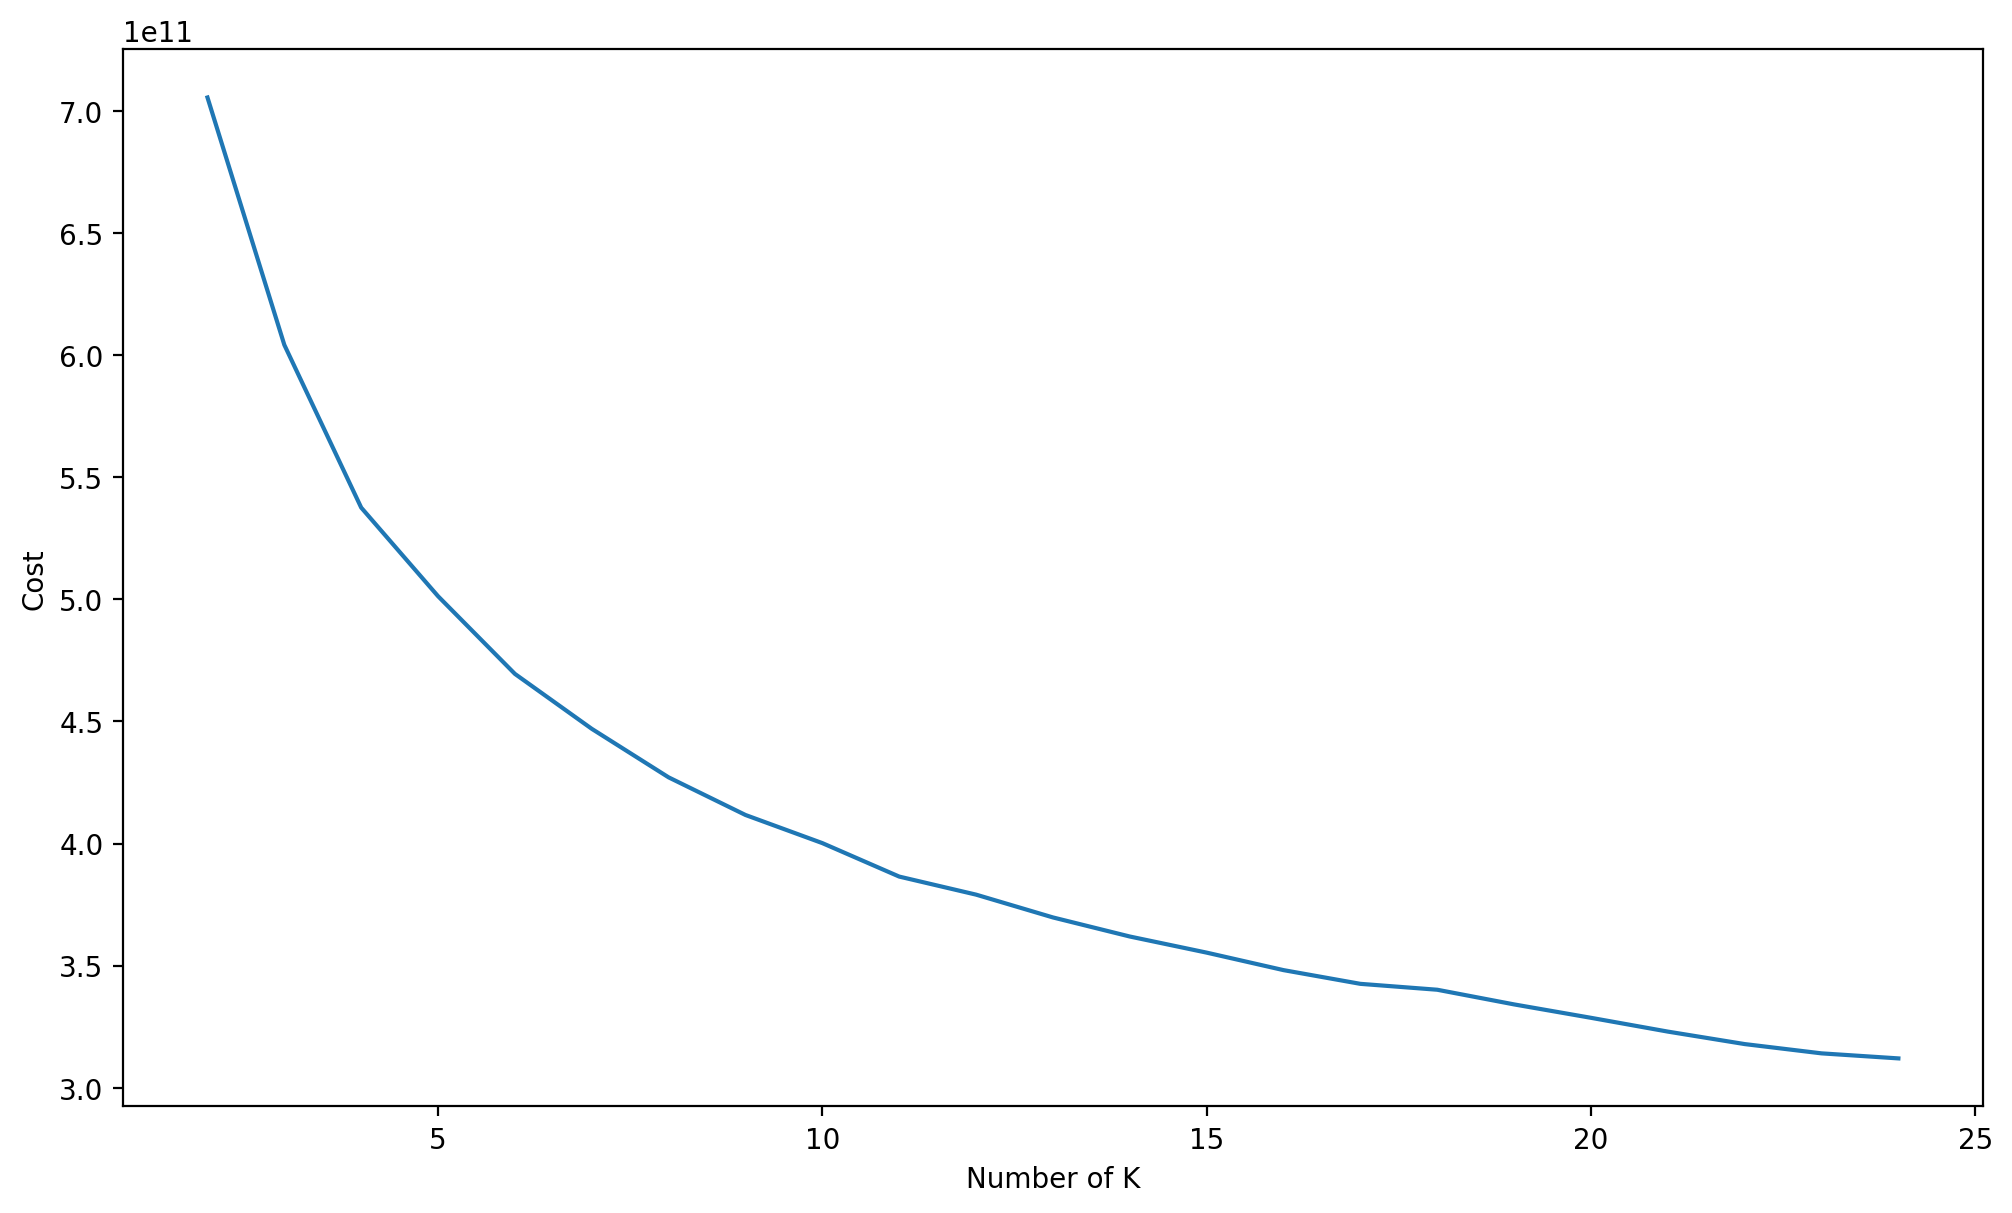

In [43]:
fig, ax = plt.subplots(1, 1, figsize =(12,7), dpi=200)
ax.plot(range(2,25),cost[2:25])
ax.set_xlabel('Number of K')
ax.set_ylabel('Cost')

**K should 16**

In [44]:
kmeans = KMeans().setK(16).setFeaturesCol("features")
KM = kmeans.fit(df_model)
resultsKM = KM.transform(df_model)
resultsKM.toPandas().head(10)

,features,song_hotness,song_id,song_title,song_year,prediction
0,"[818.4930000000002, 4310.520999999999, -4150.2...",0.355901,SOPRYBN12AB0188F46,Del Miravad,2007,10
1,"[634.8789999999999, 3489.2280000000005, -9213....",0.347873,SOGJOLI12AB0187011,House Carpenter,2005,15
2,"[549.418, 4907.5999999999985, 4424.64100000000...",0.423428,SORPZGC12A6D4F83B5,Estrella De Mar (Estrella Fugaz),2002,8
3,"[1210.3079999999995, 4622.834, -1570.700000000...",0.353943,SOFMUOF12A6D4F81C2,A,2000,0
4,"[-742.981, 4831.004, -1722.768, 2058.725999999...",0.199940,SODVFBO12AAA8C7AD2,Podzim,2007,5
5,"[422.9800000000001, 4482.146000000001, -3013.0...",0.396267,SOBNTAP12A6D4FBECD,Affections the Pay,2005,5
6,"[396.8369999999999, 4675.497999999998, 1170.23...",0.446194,SOKSWAF12A58A7C2E1,Apple Pie Bed,2009,14
7,"[-898.6479999999997, 4530.546999999999, 4838.3...",0.335156,SOBRZNR12AB017CD10,Peanuts Clu,2009,2
8,"[22.027000000000037, 3708.5579999999995, 6849....",0.425941,SOZZCYM12AF72A224A,Yaletown,2000,2
9,"[219.65500000000003, 5162.152, 4683.5110000000...",0.345624,SOOVQJT12A8C1454A3,Creatures,2009,3


### Gaussian Mixture Model

In [45]:
gm = GaussianMixture().setK(16).setFeaturesCol("features").setPredictionCol("Prediction").setProbabilityCol("Probability")
gmm = gm.fit(df_model)

In [46]:
resultsGMM= gmm.transform(df_model)
resultsGMM.toPandas().describe()

,song_hotness,song_year,Prediction
count,17346.000000,17346.000000,17346.0
mean,0.419958,2005.171625,0.0
std,0.111776,2.817051,0.0
min,0.000000,2000.000000,0.0
25%,0.367074,2003.000000,0.0
50%,0.413791,2005.000000,0.0
75%,0.472814,2007.000000,0.0
max,1.082503,2010.000000,0.0


In [36]:
for i in range(16):
    print("Component "+str(i)+" : weight is "+str(gmm.weights[i])+"\n mu vector is "+str( gmm.gaussiansDF.select('mean').head())+" \n sigma matrix is "+ str(gmm.gaussiansDF.select('cov').head()))

Component 0 : weight is 0.0625
 mu vector is Row(mean=DenseVector([145.6428, 4614.7076, 607.8716, 340.3598, 204.4787, -620.2253, -1182.4005, 47.4235, -274.9716, 412.4363, 212.5333, 8.9199])) 
 sigma matrix is Row(cov=DenseMatrix(12, 12, [830369.6205, -49226.1539, -129767.4371, -128719.5455, -75786.5436, 61870.5145, 104564.9323, -131603.9308, ..., 307164.8181, -40634.4261, -218973.6425, -74963.1096, -119248.4253, -31984.4512, -59661.4895, 274912.0519], False))
Component 1 : weight is 0.0625
 mu vector is Row(mean=DenseVector([145.6428, 4614.7076, 607.8716, 340.3598, 204.4787, -620.2253, -1182.4005, 47.4235, -274.9716, 412.4363, 212.5333, 8.9199])) 
 sigma matrix is Row(cov=DenseMatrix(12, 12, [830369.6205, -49226.1539, -129767.4371, -128719.5455, -75786.5436, 61870.5145, 104564.9323, -131603.9308, ..., 307164.8181, -40634.4261, -218973.6425, -74963.1096, -119248.4253, -31984.4512, -59661.4895, 274912.0519], False))
Component 2 : weight is 0.0625
 mu vector is Row(mean=DenseVector([145.6

*For some reasons, GMM failed to cluster the songs into 16 groups based on the MFCCs.*

### Bisecting KMeans
**We used the previous number of K, 16**

In [47]:
bkm = BisectingKMeans().setK(16).setFeaturesCol("features")
BKM = bkm.fit(df_model)
resultsBKM = BKM.transform(df_model)
resultsBKM.toPandas().head(10)

,features,song_hotness,song_id,song_title,song_year,prediction
0,"[818.4930000000002, 4310.520999999999, -4150.2...",0.355901,SOPRYBN12AB0188F46,Del Miravad,2007,2
1,"[634.8789999999999, 3489.2280000000005, -9213....",0.347873,SOGJOLI12AB0187011,House Carpenter,2005,5
2,"[549.418, 4907.5999999999985, 4424.64100000000...",0.423428,SORPZGC12A6D4F83B5,Estrella De Mar (Estrella Fugaz),2002,10
3,"[1210.3079999999995, 4622.834, -1570.700000000...",0.353943,SOFMUOF12A6D4F81C2,A,2000,12
4,"[-742.981, 4831.004, -1722.768, 2058.725999999...",0.199940,SODVFBO12AAA8C7AD2,Podzim,2007,6
5,"[422.9800000000001, 4482.146000000001, -3013.0...",0.396267,SOBNTAP12A6D4FBECD,Affections the Pay,2005,3
6,"[396.8369999999999, 4675.497999999998, 1170.23...",0.446194,SOKSWAF12A58A7C2E1,Apple Pie Bed,2009,13
7,"[-898.6479999999997, 4530.546999999999, 4838.3...",0.335156,SOBRZNR12AB017CD10,Peanuts Clu,2009,8
8,"[22.027000000000037, 3708.5579999999995, 6849....",0.425941,SOZZCYM12AF72A224A,Yaletown,2000,8
9,"[219.65500000000003, 5162.152, 4683.5110000000...",0.345624,SOOVQJT12A8C1454A3,Creatures,2009,10


*Based on the results of 3 clustering algorithms, KMeans performed the best. Hence, we'll use the result of KMeans to create the playlist.*

### Preparing the data for the recommendation engine
###### Using KMeans for clustering the songs and decision tree for the hotness of year 2010

In [48]:
cluster_data=resultsKM.toPandas()
cluster_data.head(5)

,features,song_hotness,song_id,song_title,song_year,prediction
0,"[818.4930000000002, 4310.520999999999, -4150.2...",0.355901,SOPRYBN12AB0188F46,Del Miravad,2007,10
1,"[634.8789999999999, 3489.2280000000005, -9213....",0.347873,SOGJOLI12AB0187011,House Carpenter,2005,15
2,"[549.418, 4907.5999999999985, 4424.64100000000...",0.423428,SORPZGC12A6D4F83B5,Estrella De Mar (Estrella Fugaz),2002,8
3,"[1210.3079999999995, 4622.834, -1570.700000000...",0.353943,SOFMUOF12A6D4F81C2,A,2000,0
4,"[-742.981, 4831.004, -1722.768, 2058.725999999...",0.199940,SODVFBO12AAA8C7AD2,Podzim,2007,5


In [51]:
prediction_output= prediction_ouptut.toPandas()
prediction_output.head(5)

,song_id,song_hotness,song_title,song_year
0,SOHPQHO12AC468A354,0.383746,The Consequence,2010
1,SOYPKXR12AB01876C1,0.324390,Arcade Anthem,2010
2,SOYLRVQ12AF72A04C9,0.437977,The Goal Is Your Soul,2010
3,SOIURPT12AC4688104,0.437977,A Key Turns,2010
4,SOEDCLM12AB01899B4,0.405973,Ticking Boms,2010


In [52]:
df_gui = cluster_data.merge(prediction_output,on='song_id',how="left")

In [53]:
df_gui.head(2)

,features,song_hotness_x,song_id,song_title_x,song_year_x,prediction,song_hotness_y,song_title_y,song_year_y
0,"[818.4930000000002, 4310.520999999999, -4150.2...",0.355901,SOPRYBN12AB0188F46,Del Miravad,2007,10,NaN,NaN,NaN
1,"[634.8789999999999, 3489.2280000000005, -9213....",0.347873,SOGJOLI12AB0187011,House Carpenter,2005,15,NaN,NaN,NaN
